## Model evaluation

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Statistics
using Unicode
using Random

In [ ]:
using Revise
using TokenizersLite
using TransformersLite

In [ ]:
include("../common/reporting.jl")
include("../common/vocab.jl")
include("../common/training.jl")
include("../common/SentenceClassifier.jl")

v_weighted_average (generic function with 1 method)

## Load data

raw

In [ ]:
fingerprint = "724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609"
data_dir = joinpath("..\\datasets\\amazon_reviews_multi\\en\\1.0.0\\", fingerprint)
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
filepath = joinpath(data_dir, file_train)
df = DataFrame(Arrow.Table(filepath))
println("rows: ", nrow(df))

filepath = joinpath(data_dir, file_test)
df_test = DataFrame(Arrow.Table(filepath));
println("rows: ", nrow(df_test))

rows: 200000
rows: 5000


filtered

In [ ]:
documents = df[:, :review_body]
labels = df[:, :stars]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [ ]:
documents_test = df_test[:, :review_body]
labels_test = df_test[:, :stars];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20230701_1325_n1_sen"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 4 entries:
  :tokenizer         => BytePairEncoder{String}(length(rules)=8000, length(cach…
  :indexer           => IndexTokenizer{String}(length(vocabulary)=7455, unksym=…
  :sentence_splitter => RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z…
  :model             => SentenceClassifer(base_model=TransformerClassifier{Embe…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
sentence_splitter = saved_objects[:sentence_splitter ]
@show sentence_splitter 
model = saved_objects[:model]
display(model)
display(model.base_model)
display(model.aggregate)

tokenizer = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
sentence_splitter = RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z", "C", "P", "Jul", "Eg", "Dec", "Sen", "Rev", "Mar", "BComm", "co", "Mon", "Sep", "Y", "U", "Jan", "Fig", "Prof", "al", "K", "BA", "V", "BSc", "Ph.d", "Phd", "H", "Feb", "Rep", "Mr", "S", "MA", "Jr", "PhD", "F", "W", "T", "Aug", "Dept", "L", "O", "B", "fig", "M", "Capt", "Sun", "Gen", "prof", "X", "Corp", "Gov", "Tues", "corp", "Ie", "D", "BCom", "BEng

SentenceClassifer(base_model=TransformersLite.TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{Matrix{Float32}}, Dropout{Float64, Colon, TaskLocalRNG}, Vector{TransformerEncoderBlock}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, FlattenLayer, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}(Embed((32, 7455)), PositionEncoding(32), Dropout(0.1), TransformerEncoderBlock[TransformerEncoderBlock(MultiheadAttention(num_heads=4, head_size=8, 32=>32), LayerNorm(32), Dense(32 => 128, relu), Dense(128 => 32), LayerNorm(32))], Dense(32 => 1), FlattenLayer(), Dense(30 => 1)), activation=σ, aggregate=parabolic_weighted_average)

TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(30 => 1),                       # 31 parameters
)        # Total: 21 trainable arrays, 251_328 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.082 MiB.

parabolic_weighted_average (generic function with 1 method)

In [ ]:
max_length = size(model.base_model.classifier.weight, 2)

30

## Tokenizers

In [ ]:
function pad!(v::Vector{String}, symbol::String, max_length::Int)
    if length(v) < max_length
        padding = fill(symbol, max_length - length(v))
        append!(v, padding)
    end
end

pad! (generic function with 1 method)

In [ ]:
@time documents_split = map(sentence_splitter, documents)
@time documents_test_split = map(sentence_splitter, documents_test);

 10.594693 seconds (57.00 M allocations: 3.774 GiB, 10.72% gc time, 1.10% compilation time)
  0.188366 seconds (1.41 M allocations: 94.447 MiB, 8.36% gc time)


In [ ]:
y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3
y_train = y_train[idxs];

tokens = Vector{Vector{String}}[]
@time for sentences in documents_split[idxs]
    tokens_doc = map(s->preprocess(s, tokenizer, max_length=max_length), sentences)
    pad!(tokens_doc[1], tokenizer.unksym, max_length) # hack to ensure all indices have common length
    push!(tokens, tokens_doc)
end
@time indices = map(t->indexer(t), tokens) 

X_train = indices
train_data, val_data = split_validation(MersenneTwister(2718), X_train, y_train)
println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

  9.132019 seconds (35.01 M allocations: 1.844 GiB, 9.50% gc time, 1.06% compilation time)
 22.707613 seconds (350.39 k allocations: 136.170 MiB, 0.21% compilation time)
train samples:      (144000,) (144000,)
validation samples: (16000,) (16000,)


In [ ]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3

tokens = Vector{Vector{String}}[]
@time for sentences in documents_test_split
    tokens_doc = map(s->preprocess(s, tokenizer, max_length=max_length), sentences)
    pad!(tokens_doc[1], tokenizer.unksym, max_length) # hack to ensure all indices have common length
    push!(tokens, tokens_doc)
end
@time indices_test = map(t->indexer(t), tokens) 

X_test, y_test = indices_test[idxs], y_test[idxs]
documents_test_sub = documents_test[idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  1.297149 seconds (6.58 M allocations: 198.384 MiB, 8.14% gc time, 4.41% compilation time)
  0.769496 seconds (40.39 k allocations: 6.147 MiB, 12.42% compilation time)
test indices: (5000,)
test samples: (4000,) (4000,)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [ ]:
loss(ŷ::AbstractVector, y::AbstractVector) = Flux.binarycrossentropy(ŷ, y);
accuracy(ŷ::AbstractVector, y::AbstractVector) = mean((ŷ .> 0.5) .== y);

In [ ]:
@time batched_metrics(model, train_data_loader, accuracy, loss)

106.367051 seconds (24.59 M allocations: 67.085 GiB, 11.61% gc time, 0.91% compilation time: 58% of which was recompilation)


(accuracy = 0.91480553f0, loss = 0.23389353f0)

In [ ]:
@time batched_metrics(model, val_data_loader, accuracy, loss)

 15.355877 seconds (2.60 M allocations: 7.370 GiB, 12.01% gc time)


(accuracy = 0.9120625f0, loss = 0.23229589f0)

In [ ]:
history = open(joinpath(directory, "history.json"), "r") do f
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.333835, 0.303591, 0.281763, 0.261838, 0.252773, 0.24676…
  "train_acc"  => Any[0.861708, 0.882097, 0.8915, 0.90134, 0.905715, 0.908375, …
  "val_acc"    => Any[0.852688, 0.872812, 0.881687, 0.887188, 0.889563, 0.892, …
  "val_loss"   => Any[0.344941, 0.316424, 0.302708, 0.287998, 0.283943, 0.28109…

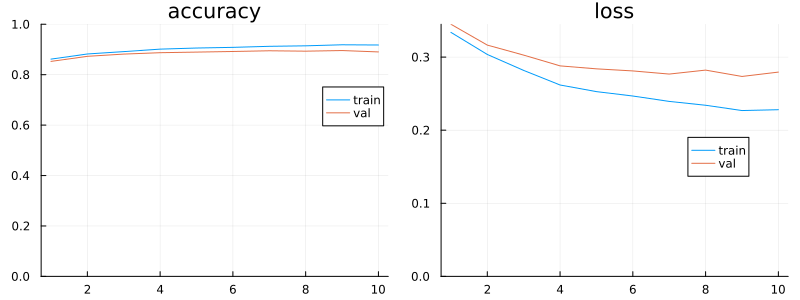

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
probs = model(X_test)
accuracy(probs, y_test)

0.8835

In [ ]:
y_pred = Int.(probs .> 0.5);

In [ ]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1746   254
  212  1788

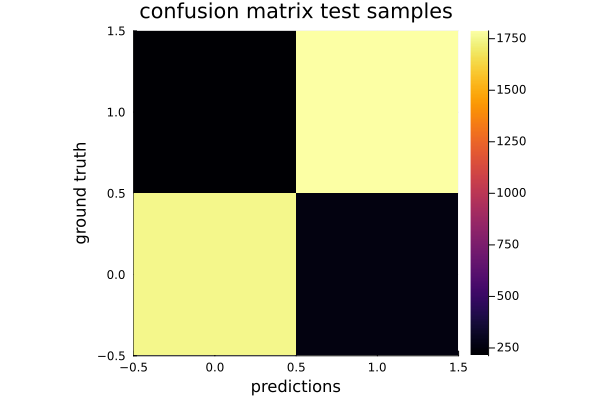

In [ ]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [ ]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.89    0.87      0.88     2000
           1       0.88    0.89      0.88     2000

weighted avg       0.88    0.88      0.88     4000

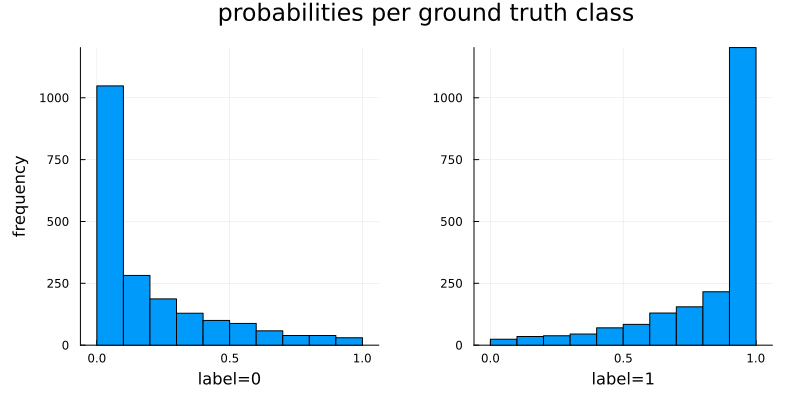

In [ ]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

### Examples

In [ ]:
pos_max = argmax(probs)
pos_min = argmin(probs)


println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, y_test[pos_max], y_pred[pos_max], probs[pos_max], documents_test_sub[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, y_test[pos_min], y_pred[pos_min], probs[pos_min], documents_test_sub[pos_min]
)

 idx  y  ŷ    prob  
2402  1  1  1.0000  They were exactly what I needed at the very affordable price and in many colors
 269  0  0  0.0000  Unfortunately never received product


In [ ]:
nshow = 3

for label in [0, 1]
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 1))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            @printf("%4d  %d  %d  %.4f\n",
                idx, y_test[idx], y_pred[idx], probs[idx], 
            )
            sentences = documents_test_split[labels_test.!==3][idx]
            y = predict_probs(model, X_test[idx])
            for (p, s) in zip(y, sentences)
                @printf("\t    %.4f %s\n", p, s)
            end
        end
    end
    println("")
end

correct: 1746 / 2000
 idx  y  ŷ    prob  
1872  0  0  0.2176
	    0.5025 Item mute the sound, but it also changed it (not good).
	    0.0232 Additionally, the seam between the 2 pieces was loose and rattled anytime I played it. -Down 3 stars- This will be a return item.
	    0.7803 I think it could be better and for the price I gave 2 stars.
 999  0  0  0.0137
	    0.0037 After 5 minutes of supervised play, the motor started making high pitched terrible screeching noises.
	    0.0360 Don't buy unless you have a tiny, useless little rat of a dog.
	    0.0042 Wasted $18.00
 848  0  0  0.0966
	    0.2916 I hate to give this product one star when it probably deserves 5.
	    0.0522 My dog has chronic itchy skin and I had high hopes that this product would be the answer to his skin issues.
	    0.2431 I'll never know because he won't eat them.
	    0.6264 At first I gave them to him as a treat.
	    0.0921 He sniffed it and walked away.
	    0.1524 I crumbled just one up in his food but he 

## Influence of sentence count

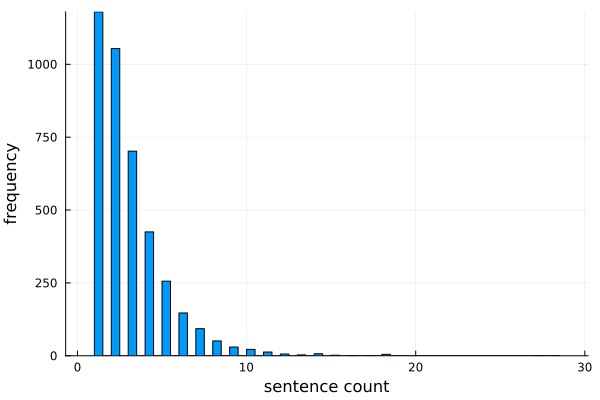

In [ ]:
sentence_counts = length.(documents_test_split[labels_test .!= 3])

p = histogram(sentence_counts, xlabel="sentence count", ylabel="frequency", label="")
savefig(p, joinpath(directory, "sentence_counts.png"))
p

In [ ]:
accuracies = Float64[]
sentence_count_frequencies = Int[]
for sentence_count in 1:maximum(sentence_counts)
    idxs = sentence_counts .== sentence_count;
    acc = count(idxs) > 0 ? accuracy(probs[idxs], y_test[idxs]) : NaN
    push!(sentence_count_frequencies, count(idxs))
    push!(accuracies, acc)
end

In [ ]:
cum_accuaracies = Float64[]
count_total = 0
acc = 0.0
for i in 1:maximum(sentence_counts)
    count_i = count(sentence_counts .== i)
    acc_i = isnan(accuracies[i]) ? 0 : accuracies[i]
    acc = (count_i * acc_i + count_total * acc)/(count_i + count_total)
    count_total += count_i
    push!(cum_accuaracies, acc)
end

In [ ]:
cum_sentence_counts = cumsum(sentence_count_frequencies  .* (1:length(sentence_count_frequencies)));
cum_sentence_counts /= cum_sentence_counts[end];

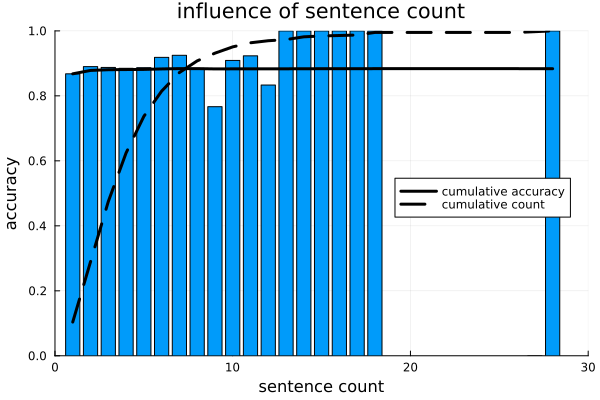

In [ ]:
bar(1:maximum(sentence_counts), accuracies, label="",
    xlabel="sentence count",
    ylabel="accuracy",
    title="influence of sentence count",
    ylims=(0, 1),
    xlims=(0, maximum(sentence_counts) + 2),
    )
p = plot!(
    1:maximum(sentence_counts), cum_accuaracies, label="cumulative accuracy", 
    legend_position=:right, color=:black, linewidth=3
)
p = plot!(
    1:maximum(sentence_counts), cum_sentence_counts, label="cumulative count",
    linewidth=3, legend_position=:right, color=:black, linestyle=:dash
)
savefig(p, joinpath(directory, "accuracy_sentence_count.png"))
p

Zoom in on graph

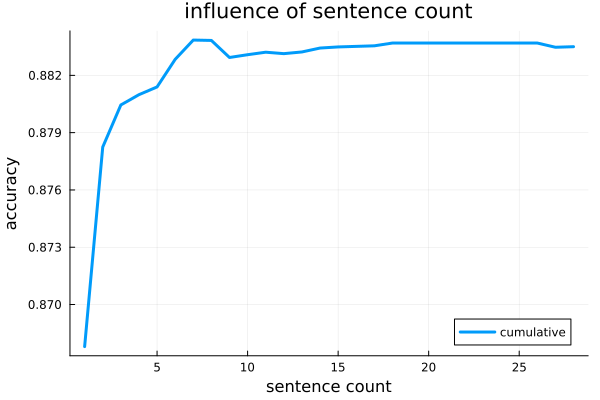

In [ ]:
p = plot(1:maximum(sentence_counts), cum_accuaracies, linewidth=3, label="cumulative",
    xlabel="sentence count",
    ylabel="accuracy",
    title="influence of sentence count",
    )
savefig(p, joinpath(directory, "accuracy_sentence_count_cummulative.png"))
p

### Test data including star=3

In [ ]:
probs_all = model(indices_test);
y_pred_all = Int.(probs_all .> 0.5);

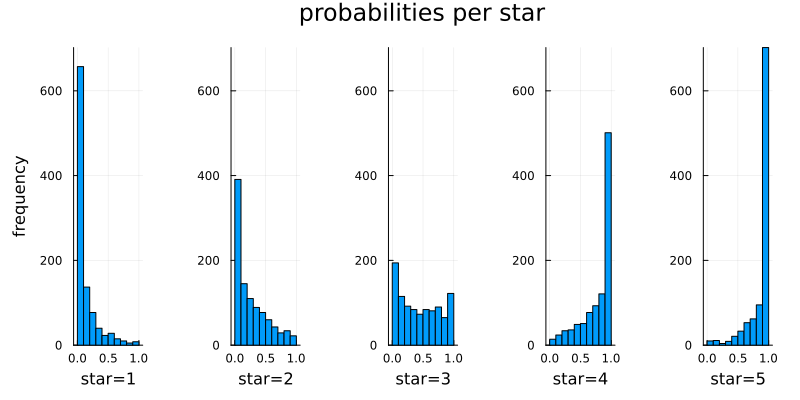

In [ ]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [ ]:
nshow = 3

star = 3
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_label, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f\n",
            idx, y_test[idx], y_pred[idx], probs[idx], 
        )
    sentences = documents_test_split[idx]
    y = predict_probs(model, X_test[idx])
    for (p, s) in zip(y, sentences)
        @printf("\t    %.4f %s\n", p, s)
    end
end

star = 3
 idx  y  ŷ    prob  
2841  1  1  0.9727
	    0.9998 I can't say enough good things about these.
	    0.9993 they are fantastic.
	    0.7408 buy them now.
2136  1  1  0.9986
	    0.9986 I think the quality is first rate.
2830  1  1  0.7326
	    0.6585 The lid to hold all the little bottles came broken.
	    0.0379 Im a crafter so i think i can work to fix it by decorating it a bit, so i won't return.
	    0.9996 This should have been wrapped in bubble wrap so this wouldn't have happened.
	    0.8879 All the little bottles are perfect.
	    0.6831 None broken.
	    0.7153 Perfect size for my use.


## Single samples

In [ ]:
idx = 4700  

text = documents_test[idx]

println(labels_test[idx])
println(text)
println("")

sentences = sentence_splitter(text)
tokens = [preprocess(s, tokenizer, max_length=max_length) for s in sentences]
for t in tokens
    println(join(t, "|"))
end
pad!(tokens[1], tokenizer.unksym, max_length)
x = indexer(tokens);

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.

⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series
⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one
⋅loved|⋅them|⋅all
⋅al|##ask|##an|⋅nights|⋅was|⋅awesome
⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman
⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending
⋅have|⋅read|⋅two|⋅other|⋅books|⋅of|⋅your|##s
⋅am|⋅looking|⋅forward|⋅to|⋅more


In [ ]:
y = predict_probs(model, x)
@printf "mean: %.4f ; weighted mean: %.4f\n" mean(y) parabolic_weighted_average(y)
for (prob, sentence) in zip(y, sentences)
    @printf("%.4f %s\n", prob, sentence)
end

mean: 0.8461 ; weighted mean: 0.9563
0.8458 This makes almost the whole series.
0.5289 Roman Nights will be the last one.
0.9998 Loved them all.
0.9893 Alaskan Nights was awesome.
0.9907 Met my expectations , hot SEAL hero, beautiful & feisty woman.
0.9837 Filled with intrigue, steamy romance & nail biting ending.
0.6350 Have read two other books of yours.
0.7959 Am looking forward to more.
